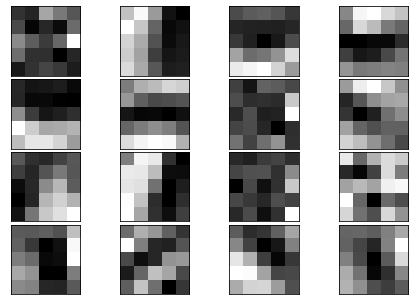

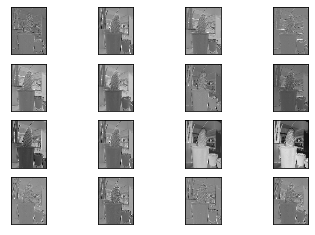

In [1]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 학습된 가중치
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/cactus_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [2]:
import numpy as np
from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

W1 5.080283264748344e-07
b1 1.448947443282632e-06
W2 3.8109693837087724e-11
b2 4.729897866212127e-09
W3 2.1656877008921265e-10
b3 1.7990195529116182e-07


In [3]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.2992385257989927
=== epoch:1, train acc:0.103, test acc:0.109 ===
train loss:2.2976492968889595
train loss:2.294529319528135
train loss:2.2872119427965223
train loss:2.2789876944379794
train loss:2.2681210670460588
train loss:2.2540400176036473
train loss:2.2333410971538314
train loss:2.2204299586163563
train loss:2.1879572874178543
train loss:2.1779493277364126
train loss:2.110886826338491
train loss:2.0782036188699506
train loss:2.037183316092976
train loss:2.0096722698518525
train loss:1.9019766631508173
train loss:1.881545274592184
train loss:1.7714601889191959
train loss:1.722138949921664
train loss:1.6877070789393418
train loss:1.5647323875890335
train loss:1.4939948886020122
train loss:1.4038041821343452
train loss:1.3843492581611077
train loss:1.341463795684202
train loss:1.1862617576824364
train loss:1.0607739752101073
train loss:1.0575332409594325
train loss:1.0610739081191396
train loss:0.9096768913799032
train loss:0.9801480422080264
train loss:0.82864053632771

train loss:0.3759239345513794
train loss:0.3664798678631901
train loss:0.17574071081803466
train loss:0.24765009025340604
train loss:0.19786161422978832
train loss:0.234584395962185
train loss:0.2510778997991901
train loss:0.24320862686846723
train loss:0.12500635847571412
train loss:0.2827995355123948
train loss:0.1783331562965529
train loss:0.18791253525598428
train loss:0.20621236539978763
train loss:0.14076282725295353
train loss:0.18996402388931152
train loss:0.23949381664946479
train loss:0.2615297781408988
train loss:0.33324917893798905
train loss:0.32744194463399084
train loss:0.30359603968129695
train loss:0.21603106920068002
train loss:0.1475436701261329
train loss:0.25709081125787897
train loss:0.20771589797345003
train loss:0.1715763766833806
train loss:0.11448521659032705
train loss:0.29247926330735174
train loss:0.1694271509843652
train loss:0.1467054170676211
train loss:0.24037577266895
train loss:0.20376190373361813
train loss:0.20851921528045522
train loss:0.2431964365

train loss:0.12068572999006116
train loss:0.12461626907121082
train loss:0.15577178797053753
train loss:0.11282181240590333
train loss:0.107173637167072
train loss:0.2563463006646311
train loss:0.10399285280630118
train loss:0.09966783110324401
train loss:0.1465374241922505
train loss:0.1293000782078129
train loss:0.24665917862883333
train loss:0.16873628297425572
train loss:0.11340079713118549
train loss:0.20713717820034042
train loss:0.11193655803813235
train loss:0.1142089710913089
train loss:0.14040379862010957
train loss:0.0982805766418849
train loss:0.08807782402116915
train loss:0.2108002953338589
train loss:0.14541851796358224
train loss:0.13910908241012043
train loss:0.16922073437700985
train loss:0.03470848466694633
train loss:0.36124483447395334
train loss:0.10980299512314907
train loss:0.2134010014468814
train loss:0.08156861538579786
train loss:0.17330220107331215
train loss:0.09667140999020471
train loss:0.17603290672073058
train loss:0.08645308258877972
train loss:0.1698

train loss:0.03332790685715985
train loss:0.10244093882222378
train loss:0.13529231570608902
train loss:0.07102297116967395
train loss:0.13717324679269224
train loss:0.050943921515316994
train loss:0.04785229887630794
train loss:0.05093497318419157
train loss:0.13038065363104562
train loss:0.08384567497725973
train loss:0.1444964187846838
train loss:0.03355133265478239
train loss:0.12090252921429856
train loss:0.12336538002734466
train loss:0.03181654904819641
train loss:0.0539787373973727
train loss:0.1657598414076419
train loss:0.1537930206657256
train loss:0.05065664793886333
train loss:0.08357261675094022
train loss:0.036198701461690484
train loss:0.029658265859351877
train loss:0.10096449983342895
train loss:0.07700834634580507
train loss:0.10063920943821347
train loss:0.061668167955416714
train loss:0.04951581802049453
train loss:0.12253014411671082
train loss:0.03162687364954492
train loss:0.13398927487745285
train loss:0.07644219027161765
train loss:0.059954869675233634
train l

train loss:0.06188470745016866
train loss:0.0533663382427614
train loss:0.09382335156222915
train loss:0.15541839638207383
train loss:0.023862339405459884
train loss:0.09591367289407657
train loss:0.04130341327543228
train loss:0.022424045556730606
train loss:0.05044029042680474
train loss:0.0972777610223419
train loss:0.049017283351674525
train loss:0.07325867673990842
train loss:0.05137516622684487
train loss:0.08675405086600259
train loss:0.03859989280095029
train loss:0.05517874119831522
train loss:0.05973801115298068
train loss:0.053056054860027665
train loss:0.0976233292217156
train loss:0.048647890615092455
train loss:0.06824955944785494
train loss:0.08293132240332729
train loss:0.05054132316418368
train loss:0.07238000458107996
train loss:0.03844919128064013
train loss:0.11073137737868566
train loss:0.07682590073031755
train loss:0.04451001572934788
train loss:0.02117707446021179
train loss:0.010903206725169283
train loss:0.06823653772636354
train loss:0.04540179582104965
train

train loss:0.031053314001833116
train loss:0.0346950783641672
train loss:0.06114929076245608
train loss:0.04418176812964524
train loss:0.02879547565299978
train loss:0.06200561998687801
train loss:0.09912402135543477
train loss:0.02808751620443652
train loss:0.07753679164653426
train loss:0.030199877962310114
train loss:0.09234020003328178
train loss:0.026250263663392143
train loss:0.04976694821378916
train loss:0.06898521968124065
train loss:0.13823746495095457
train loss:0.03292988749468679
train loss:0.03829675100659858
train loss:0.18443024728173374
train loss:0.027400078476231694
train loss:0.02571767115600703
train loss:0.05569642137568105
train loss:0.12758160230527418
train loss:0.07200607778664361
train loss:0.02195778027328164
train loss:0.09250407917005495
train loss:0.034672717235478
train loss:0.04628870656988452
train loss:0.0681251459362871
train loss:0.14823860083112927
train loss:0.10153832485387264
train loss:0.018583716991330913
train loss:0.05000345905575926
train l

train loss:0.07688440916206311
train loss:0.03308786750612292
train loss:0.013665647998499602
train loss:0.04591775692131099
train loss:0.062133655856019
train loss:0.04696082829757679
train loss:0.058327786069256676
train loss:0.04248056998161468
train loss:0.03271734374785085
train loss:0.02717253435058677
train loss:0.012097895537390484
train loss:0.032420893721957784
train loss:0.056216657769849805
train loss:0.04400108612100423
train loss:0.04397881362724904
train loss:0.02361380177546863
train loss:0.012225375670823968
train loss:0.014224533473360364
train loss:0.016645221237874153
train loss:0.07452682440261435
train loss:0.08002909740884094
train loss:0.06466264121452302
train loss:0.06968736951376686
train loss:0.06116656707348571
train loss:0.09678630911376042
train loss:0.02182996344146325
train loss:0.016451079549463607
train loss:0.021020043430041442
train loss:0.021423174778734507
train loss:0.061895645086465195
train loss:0.15629184920038358
train loss:0.0466097881651585

train loss:0.04630528049491718
train loss:0.026002619372822108
train loss:0.056723989043721584
train loss:0.014774609616621281
train loss:0.021515002652372918
train loss:0.06473179816126319
train loss:0.06645531582630651
train loss:0.013848004087916739
train loss:0.007376258740694784
train loss:0.06514771168229909
train loss:0.041638096885083416
train loss:0.026286120150901898
train loss:0.02501794024161817
train loss:0.0235934534259868
train loss:0.03956044106800122
train loss:0.07175501507711977
train loss:0.03664621251128497
train loss:0.02425247802352203
train loss:0.028976975869282627
train loss:0.006229067525378088
train loss:0.02282151447955553
train loss:0.021371285977680055
train loss:0.03276891385654229
train loss:0.055269884146990876
train loss:0.009191295499124834
train loss:0.01699648292437344
train loss:0.012624343981345829
train loss:0.022778336388797022
train loss:0.04763207007323463
train loss:0.0064121939347798525
train loss:0.0874834113747763
train loss:0.04754376665

train loss:0.018797922693220004
train loss:0.020538007896414415
train loss:0.01910572295017943
train loss:0.037480558622697446
train loss:0.010339892685502722
train loss:0.018911420236644202
train loss:0.03206948613722055
train loss:0.083007614893756
train loss:0.027521765338753626
train loss:0.032987889327483616
train loss:0.0181670096297041
train loss:0.043817940843854465
train loss:0.051380200638513805
train loss:0.03744233395151657
train loss:0.053057221149305
train loss:0.009176004299425803
train loss:0.03448765550735225
train loss:0.06857747321782019
train loss:0.007446124789415956
train loss:0.016552402109688814
train loss:0.052227934131597174
train loss:0.027759852360735117
train loss:0.020361384155055392
train loss:0.03555437545367313
train loss:0.02848320313615796
train loss:0.04862194524396335
train loss:0.03414578291969752
train loss:0.013803380100273942
train loss:0.04839226403072487
train loss:0.03374372579720715
train loss:0.04941631699633347
train loss:0.021149780132303

train loss:0.0837284335985073
train loss:0.018122004854153273
train loss:0.005472604126418966
train loss:0.021487552269874085
train loss:0.05416659477788891
train loss:0.008840700313164576
train loss:0.044803350486726054
train loss:0.022512462350763526
train loss:0.01744974246531079
train loss:0.06427400529186325
train loss:0.019774603202870177
train loss:0.12454661463246293
train loss:0.06907501897406887
train loss:0.011529212378933373
train loss:0.03228887525982328
train loss:0.03731695698243437
train loss:0.10980025251630651
train loss:0.033748015784340696
train loss:0.0071148368962345035
train loss:0.036057463176191795
train loss:0.009307147573456995
train loss:0.06269463939221874
train loss:0.016851237311490755
train loss:0.026576502864812824
train loss:0.09489625781803498
train loss:0.004978373721400924
train loss:0.07130256020617015
train loss:0.012362519421452712
=== epoch:5, train acc:0.989, test acc:0.985 ===
train loss:0.015441280773288263
train loss:0.04412789777836145
trai

train loss:0.02302449921346686
train loss:0.0030640966855658884
train loss:0.030107523426612805
train loss:0.0038920913333133655
train loss:0.026383763213897272
train loss:0.031769173789083414
train loss:0.007326570219329887
train loss:0.013293668859111856
train loss:0.028221727155258884
train loss:0.08265821138571072
train loss:0.03160766352617162
train loss:0.012058859538043833
train loss:0.02339060481038134
train loss:0.027844304131205214
train loss:0.003164360570016622
train loss:0.007321623088159353
train loss:0.019459584465427913
train loss:0.03671188679245181
train loss:0.030468420973178315
train loss:0.04316554588726206
train loss:0.011268842837692776
train loss:0.018603738968810977
train loss:0.016396233402426914
train loss:0.011703922771005704
train loss:0.053309024798324146
train loss:0.0050446589410364975
train loss:0.023860222195000676
train loss:0.008464990677696599
train loss:0.01383153859572903
train loss:0.01825764751213128
train loss:0.023995808227578554
train loss:0.

train loss:0.0022856114931950715
train loss:0.00405620275653925
train loss:0.008578923814355967
train loss:0.010231906420558348
train loss:0.03543424071865922
train loss:0.01190945076075266
train loss:0.046314249878404115
train loss:0.02312020976437866
train loss:0.014308791103484519
train loss:0.02050294669523023
train loss:0.018281456252352547
train loss:0.039184791917052895
train loss:0.007525040918299583
train loss:0.019401476541092467
train loss:0.06382276495146343
train loss:0.06688235397962641
train loss:0.027306751093617434
train loss:0.019136244941451542
train loss:0.013750613280453747
train loss:0.02120804311471861
train loss:0.003915163744697234
train loss:0.015255110423780225
train loss:0.008051059165482467
train loss:0.013885039364869598
train loss:0.025054353060769096
train loss:0.011241799813690166
train loss:0.01922191724680084
train loss:0.02559696584048949
train loss:0.01945241748116561
train loss:0.037118020204309224
train loss:0.0034046990546871673
train loss:0.0031

train loss:0.009684005977867002
train loss:0.022617018967945494
train loss:0.06538055510888523
train loss:0.007023179251328795
train loss:0.06628330101898544
train loss:0.0030511433067772274
train loss:0.005513613805811291
train loss:0.026383741264892725
train loss:0.008804141974168437
train loss:0.08143775179788436
train loss:0.005403263029498562
train loss:0.003612077302623582
train loss:0.014556525741085586
train loss:0.009904149695081053
train loss:0.03844397759338792
train loss:0.01674077658924162
train loss:0.009287877855308477
train loss:0.007321623026071455
train loss:0.023715426216772428
train loss:0.023262445668775854
train loss:0.007509946668051775
train loss:0.0022600753740479734
train loss:0.008465647556994365
train loss:0.010412174564787414
train loss:0.02409819495055075
train loss:0.017877240679772043
train loss:0.046656510887057745
train loss:0.008693441570118868
train loss:0.00866162074594429
train loss:0.0017667039052586782
train loss:0.010733688374598703
train loss:0

train loss:0.043716452372139926
train loss:0.019395218776895685
train loss:0.010920865088657045
train loss:0.0026659649419346417
train loss:0.012016938093353254
train loss:0.011227281790015498
train loss:0.03135785105704279
train loss:0.010254077631292609
train loss:0.02153412753238958
train loss:0.009412179509206475
train loss:0.012836493678600134
train loss:0.024557307337776196
train loss:0.010259308868526806
train loss:0.0021414640677404548
train loss:0.014149993445957014
train loss:0.0025658927081646226
train loss:0.007283058528018286
train loss:0.014959542963024286
train loss:0.009589608738254872
train loss:0.013794536971335848
train loss:0.0028152290168572806
train loss:0.0007640341719841443
train loss:0.012112437856589784
train loss:0.015775137300765896
train loss:0.10934935220978163
train loss:0.012937389504584477
train loss:0.04510234042142346
train loss:0.018209794338946605
train loss:0.05010523254093337
train loss:0.01146417801462263
train loss:0.0073063983273442545
train lo

train loss:0.00947483069715675
train loss:0.12358543067729229
train loss:0.009338982457463512
train loss:0.012309420498111371
train loss:0.018657094576600045
train loss:0.013449761885109504
train loss:0.010565474168895868
train loss:0.004884392590665503
train loss:0.0014789186082710055
train loss:0.0419488195403866
train loss:0.031486724184161326
train loss:0.015936654518030228
train loss:0.00572196626978984
train loss:0.022483331070608695
train loss:0.039252598958673966
train loss:0.015328689840885827
train loss:0.01152810746985208
train loss:0.006547468808483559
train loss:0.010741336019087945
train loss:0.006395071864405174
train loss:0.0026143547312144823
train loss:0.030711017345586473
train loss:0.028237953352859783
train loss:0.008377571638962612
train loss:0.06040661309727079
train loss:0.014091829066926756
train loss:0.013056544999790415
train loss:0.007484320297850584
train loss:0.011925207592692073
train loss:0.0016485864126629419
train loss:0.034898691078925424
train loss:0

train loss:0.013650234629021853
train loss:0.006400068709353399
train loss:0.001361374205243386
train loss:0.035367630262119754
train loss:0.004724931233648523
train loss:0.005283955104225192
train loss:0.0027950765426355733
train loss:0.008365657575191851
train loss:0.0019108160560180527
train loss:0.035612862887332855
train loss:0.010903195230070883
train loss:0.0049498374382623365
train loss:0.004552963016624531
train loss:0.01105964936608105
train loss:0.006515305185196628
train loss:0.003678246066077952
train loss:0.046776244040281946
train loss:0.010138079512375466
train loss:0.0043104334959067694
train loss:0.003601057667858129
train loss:0.09247856263169908
train loss:0.03943134387495531
train loss:0.004835287339579455
train loss:0.019101300522615567
train loss:0.004397722132999682
train loss:0.00572700480047866
train loss:0.00600645829268895
train loss:0.0061931751568597105
train loss:0.011854009514168899
train loss:0.05586750761346354
train loss:0.0356516820481921
train loss:

train loss:0.005536488224428555
train loss:0.004236705841423929
train loss:0.0033240949857176725
train loss:0.011003049958177764
train loss:0.0048671214809586395
train loss:0.00843636372422082
train loss:0.03263604067487822
train loss:0.02466126205867568
train loss:0.008065043194564234
train loss:0.004233074381483187
train loss:0.0004345437187667981
train loss:0.011081891406964415
train loss:0.006246051625500416
train loss:0.016416663707527188
train loss:0.007159630487138842
train loss:0.0069976777608199555
train loss:0.012171465072053432
train loss:0.011806926565917506
train loss:0.007199710823281971
train loss:0.010278546278285068
train loss:0.02164931895128816
train loss:0.017370261973863897
train loss:0.0040826518210168436
train loss:0.005076449673595794
train loss:0.017157406246816328
=== epoch:8, train acc:0.989, test acc:0.989 ===
train loss:0.005002766711329137
train loss:0.0028005809385233003
train loss:0.012111621826383196
train loss:0.010249541757800134
train loss:0.01817605

train loss:0.008648116734934382
train loss:0.041817942243889704
train loss:0.007327255686899538
train loss:0.009409112575737111
train loss:0.010893901864657218
train loss:0.0014763627414729407
train loss:0.004661799017922906
train loss:0.0033640602244700618
train loss:0.002253779915056629
train loss:0.004604569607080794
train loss:0.07657248053263965
train loss:0.002938715194089832
train loss:0.008116236991274844
train loss:0.0034529068508016465
train loss:0.007800307422530311
train loss:0.007819294427123303
train loss:0.005828627179841683
train loss:0.016039590300631644
train loss:0.0125322552373684
train loss:0.02650292145242537
train loss:0.008052719883118425
train loss:0.0051866643385107755
train loss:0.014675384320688182
train loss:0.003404073875583532
train loss:0.002892374580885428
train loss:0.0074455993560614804
train loss:0.003964351840870021
train loss:0.002590917629785106
train loss:0.0011103644517130953
train loss:0.003772978902890778
train loss:0.008022690642989464
train 

train loss:0.0013854665477245653
train loss:0.0028278356716122523
train loss:0.011046610435426651
train loss:0.01690295229619212
train loss:0.00719191405672666
train loss:0.005470984476558335
train loss:0.01974732220408414
train loss:0.01597886377364187
train loss:0.03582792884406322
train loss:0.004466273315427016
train loss:0.03167795163633789
train loss:0.05253172381824278
train loss:0.005440085404997769
train loss:0.007870150005593247
train loss:0.00947422478775943
train loss:0.013288716502885543
train loss:0.015281118401784128
train loss:0.005931092471959002
train loss:0.021169119470053527
train loss:0.0034759580767601377
train loss:0.006992676728258129
train loss:0.002458137587892766
train loss:0.003492660833631947
train loss:0.0024558201148841695
train loss:0.001689051254350918
train loss:0.03713239900260278
train loss:0.0007465116508078011
train loss:0.011008394072644288
train loss:0.0031396616329752033
train loss:0.08978833666507366
train loss:0.021909380874308014
train loss:0

train loss:0.007511805622288585
train loss:0.009478239417183404
train loss:0.011458617136441257
train loss:0.002001606729132521
train loss:0.0010930507582300358
train loss:0.043034282136128234
train loss:0.007115268792042137
train loss:0.00901021978743446
train loss:0.006158229669769544
train loss:0.0068033254503389
train loss:0.01838841107926766
train loss:0.0058403727893225985
train loss:0.017901037984208598
train loss:0.019939378953910215
train loss:0.0053830514544558825
train loss:0.010915357482845863
train loss:0.00361304272112474
train loss:0.005114056505878895
train loss:0.010133244140621613
train loss:0.006943407662953525
train loss:0.011197893847142322
train loss:0.09931079046364989
train loss:0.02313229742471024
train loss:0.005951854208088381
train loss:0.010751481998874584
train loss:0.009163927232658494
train loss:0.005338838379907156
train loss:0.03075182214033304
train loss:0.012524972244931992
train loss:0.010322836597304009
train loss:0.006310846766897746
train loss:0.

train loss:0.010323197154369352
train loss:0.006896735882033206
train loss:0.004156698531140432
train loss:0.004877366544137167
train loss:0.010006164919605771
train loss:0.0013555776983703016
train loss:0.001822837123515019
train loss:0.008507318279739943
train loss:0.011320804796719906
train loss:0.005211204739445672
train loss:0.008972761812189945
train loss:0.0022116784938152915
train loss:0.0058134533932354335
train loss:0.02669786038865612
train loss:0.020042307308965786
train loss:0.0016478547580238197
train loss:0.07865242652993405
train loss:0.0013144425390700654
train loss:0.008891380544071075
train loss:0.0032985007688535817
train loss:0.0014884028962688517
train loss:0.010137154698921536
train loss:0.021509975713568896
train loss:0.003561504139692182
train loss:0.0033431978547624835
train loss:0.01277946308496408
train loss:0.002289953890139464
train loss:0.005437513371082963
train loss:0.0027025387456435256
train loss:0.006914591565987487
train loss:0.010242886675304468
tr

train loss:0.007848025903905277
train loss:0.009191052801018586
train loss:0.02259701850170936
train loss:0.008000846721870519
train loss:0.005891269135187564
train loss:0.05355221858450378
train loss:0.005603312470062927
train loss:0.007347588286977984
train loss:0.027847769157967425
train loss:0.003711102899783844
train loss:0.00798713241171559
train loss:0.00895787082180237
train loss:0.004449104854068586
train loss:0.02197310553892728
train loss:0.01657942926836731
train loss:0.054395539733592874
train loss:0.004975848086959239
train loss:0.003358301130742233
train loss:0.03482053337213699
train loss:0.0031596570080537163
train loss:0.0028971462444237466
train loss:0.01094068552934155
train loss:0.0020062719739470437
train loss:0.006274753367017046
train loss:0.000979161539953217
train loss:0.0055354701826546
train loss:0.007602527336669796
train loss:0.014555728262734236
train loss:0.0024242693032096273
train loss:0.0007537516214269345
train loss:0.005798778061839277
train loss:0.

train loss:0.015335131885291831
train loss:0.016189111891340122
train loss:0.005198367401077267
train loss:0.007740220080215703
train loss:0.0035240454753874754
train loss:0.008437188193854982
train loss:0.0045385170019648395
train loss:0.00782729637716128
train loss:0.00044184356738760996
train loss:0.0007173817223817647
train loss:0.001954161250535848
train loss:0.005301892547931637
train loss:0.009997832256038612
train loss:0.0063454770353048185
train loss:0.018062400000651752
train loss:0.00450444532654795
train loss:0.004668733550796834
train loss:0.002130912466808115
train loss:0.0009595512010277914
train loss:0.002374049992638237
train loss:0.004561410674404202
train loss:0.003342287092077534
train loss:0.0064112976817791625
train loss:0.0010993435216251459
train loss:0.008242918167744416
train loss:0.0024331611711549466
train loss:0.0034187877688683726
train loss:0.009938991415575343
train loss:0.004278426845982025
train loss:0.0031705952357231133
train loss:0.00205647072694403

train loss:0.0021465130734263154
train loss:0.0003009227728040129
train loss:0.003357850651266758
train loss:0.0100653826029579
train loss:0.0012628131944566515
train loss:0.004521032268936951
train loss:0.02548151353894005
train loss:0.004968141290081181
train loss:0.0009596912510215891
train loss:0.005711507776782283
train loss:0.0019902340975319088
train loss:0.004073628094338125
train loss:0.006425187305668592
train loss:0.012786601965235664
train loss:0.0018001179052548073
train loss:0.0058227262682122175
train loss:0.0030062926340032907
train loss:0.03903691376453007
train loss:0.03946108118071583
train loss:0.02900922744039716
train loss:0.007271011121444372
train loss:0.014413869893107086
train loss:0.0045187478388361265
train loss:0.0015675212995301608
train loss:0.0088029320923789
train loss:0.0007537437670479788
train loss:0.003353091243702557
train loss:0.025960550025273418
train loss:0.0014932149462286656
train loss:0.005632611925545262
train loss:0.005178778553642829
trai

train loss:0.008881977259387141
train loss:0.0011641031088843704
train loss:0.0014779089133794597
train loss:0.00471653265205865
train loss:0.0014466879654973105
train loss:0.0011248407791050784
train loss:0.021073420998734726
train loss:0.0006072288552092981
train loss:0.006807273668753435
train loss:0.003116045900423716
train loss:0.0031202831001778016
train loss:0.0016831065153478384
train loss:0.005322318641119778
train loss:0.01195857878119068
train loss:0.001862584299515884
train loss:0.004126141884493454
train loss:0.00063250559120142
train loss:0.002607550084307163
train loss:0.000980805128519944
train loss:0.013027730533600863
train loss:0.0007550912467425583
train loss:0.000703481329074576
train loss:0.026206808147378045
train loss:0.010022961812579221
train loss:0.0030849430517209345
train loss:0.0041828922183017436
train loss:0.002478140804061561
train loss:0.0015417599540255068
train loss:0.003993989446758321
train loss:0.003678100879264956
train loss:0.000867568280919771


train loss:0.004447076536893202
train loss:0.006120539815899936
train loss:0.01474108613637235
train loss:0.00238938141702812
train loss:0.006605884825525029
train loss:0.0070492467484277385
train loss:0.0014680631863908521
train loss:0.00027438596793599143
train loss:0.004395426228505874
train loss:0.0029821796986918255
train loss:0.011717884628121766
train loss:0.0067629130944975415
train loss:0.004652067997083315
train loss:0.010988167938653662
train loss:0.0026305598588506245
train loss:0.004790086015723992
train loss:0.002450359263130539
train loss:0.016532750360072245
train loss:0.004101125604544465
train loss:0.00016415402880296388
train loss:0.007703212155011504
train loss:0.023042544956810667
train loss:0.011595285723621819
train loss:0.004582266102048293
train loss:0.009487127240419524
train loss:0.001639146078077839
train loss:0.0027684207893109757
train loss:0.006363957691922503
train loss:0.0013208959150419711
train loss:0.03626990135171853
train loss:0.003972670295158033


train loss:0.004917466587883255
train loss:0.00035924308964185804
train loss:0.0026339132887032855
train loss:0.0025658408326778206
train loss:0.0009236649492217261
train loss:0.0014566552303204611
train loss:0.002037107750079802
train loss:0.003602428545293324
train loss:0.002128253862765694
train loss:0.002382402061900695
train loss:0.00390721467116901
train loss:0.001458340651534962
train loss:0.007049116084300591
train loss:0.0050030924250679355
train loss:0.0049785411917252324
train loss:0.0022863202800863154
train loss:0.0018685147659904572
train loss:0.002763421615418501
train loss:0.0029615415687681184
train loss:0.02298629246659324
train loss:0.0038199307394237753
train loss:0.00662693262737981
train loss:0.003741711573559028
train loss:0.03271007955448926
train loss:0.015479307427387602
train loss:0.0015277055112217072
train loss:0.036434709697745274
train loss:0.0039789552487539
train loss:0.0016171460488559992
train loss:0.006324984927565962
train loss:0.0039911345543955255

train loss:0.001134614728028968
train loss:0.0017718405227314727
train loss:0.002366421938940624
train loss:0.002405876294941183
train loss:0.010524033938184496
train loss:0.002858734438498402
train loss:0.009535796951851553
train loss:0.0026104478317725984
train loss:0.005198733432353391
train loss:0.0059818063702243365
train loss:0.003128286770344873
train loss:0.002331394261098742
train loss:0.006013697844475877
train loss:0.007451466008813032
train loss:0.002274333318425256
train loss:0.0024160756319532377
train loss:0.004653448995178211
train loss:0.0016044927110771404
train loss:0.012315840759230976
train loss:0.0011056067534981804
train loss:0.004282881717900116
train loss:0.0432521908423133
train loss:0.0008657055671238791
train loss:0.000932730628566921
train loss:0.0003623236650293361
train loss:0.0003857130289771429
train loss:0.0008728999519669919
train loss:0.00023238530318725082
train loss:0.005265145312607353
train loss:0.001311361772667204
train loss:0.00117420285773657

train loss:0.0026930201234421167
train loss:0.0009362781297175494
train loss:0.01136793113051318
train loss:0.0001877689076791585
train loss:0.0019778689809640333
train loss:0.001868759718336359
train loss:0.004951476489283011
train loss:0.002113203319889667
train loss:0.0005520659643866179
train loss:0.0031222223929528847
train loss:0.021349831980660854
train loss:0.010308461110024963
train loss:0.008698440838632951
train loss:0.013709446354276098
train loss:0.0056057937506810195
train loss:0.025728691551133397
train loss:0.01599015524803971
train loss:0.0010304488226612158
train loss:0.011469957684458233
train loss:0.003120681886319832
train loss:0.0019462265328680556
train loss:0.006450938897406932
train loss:0.0022669626824918273
train loss:0.0038491520452972267
train loss:0.0019004248376228363
train loss:0.00613821242800713
train loss:0.016605197237315114
train loss:0.002937512175168272
train loss:0.003365507639254677
train loss:0.031123707600816727
train loss:0.05483004937534511


train loss:0.0017556977670287633
train loss:0.0014783651098573566
train loss:0.0013405650688660554
train loss:0.02023749238062927
train loss:0.006037729049396329
train loss:0.005329418605438773
train loss:0.004182749277626382
train loss:0.009466380953125426
train loss:0.003480446195745736
train loss:0.006049072064438999
train loss:0.0016274071855143823
train loss:0.0030727979932655743
train loss:0.0035879680844769853
train loss:0.00020287678570211082
train loss:0.002792365622898109
train loss:0.0034674728281305156
train loss:0.010850457624277802
train loss:0.0010234523692483409
train loss:0.0019966025090381594
train loss:0.005202265698035427
train loss:0.0006862490960966523
train loss:0.0006736369036297645
train loss:0.006104600640063307
train loss:0.028646151124862632
train loss:0.0018554410871626614
train loss:0.0010865837127924565
train loss:0.005967333766484625
train loss:0.004769381888392325
train loss:0.015709158680087786
train loss:0.0003647104047208808
train loss:0.001187331288

train loss:0.002489962002050833
train loss:0.010355915101239167
train loss:0.00029950953831196526
train loss:0.007645016871537517
train loss:0.00047932934558816287
train loss:0.0006012453091307873
train loss:0.0029655633676289998
train loss:0.006465534949113796
train loss:0.004806448185783542
train loss:0.0028054102788044764
train loss:0.0009769757941207003
train loss:0.0035370685540573664
train loss:0.018169059331967153
train loss:0.000878304756040876
train loss:0.029227208896904666
train loss:0.001231519138563934
train loss:0.004737857644879136
train loss:0.002485035773478786
train loss:0.0013043808878387376
train loss:0.0020460207692026195
train loss:0.002077166378150645
train loss:0.0009185678381205283
train loss:0.0008715496011677682
train loss:0.00012724794900465246
train loss:0.002829606866306114
train loss:0.007881282739270093
train loss:0.0002818859240357897
train loss:0.005303690670197009
train loss:0.0036555404018041855
train loss:0.01174430346318053
train loss:0.01059857721

train loss:0.0004772749327968423
train loss:0.00205439456961596
train loss:0.006161471237338114
train loss:0.027565046679998248
train loss:0.03628048003301896
train loss:0.00043863489376945843
train loss:0.002648747583699895
train loss:0.0005040971033039249
train loss:0.0019349147612659175
train loss:0.026891595137333454
train loss:0.0005953701555951942
train loss:0.0001953128039812021
train loss:0.0014415134101600812
train loss:0.00046910665143721353
train loss:0.0018516948015636124
train loss:0.00018042174790434257
train loss:0.0009428516250558175
train loss:0.0011088097470494615
train loss:0.006605197649859163
train loss:0.0018259475314398638
train loss:0.0005079116480445546
train loss:0.0015997188248537942
train loss:0.0015864373204764845
train loss:0.0037855147317920014
train loss:0.01318359206650368
train loss:0.00016060639305456878
train loss:0.0009201328836305182
train loss:0.0030902449535688908
train loss:0.0005839980301896126
train loss:0.013206585255669857
train loss:0.00451

train loss:0.0007644877280773823
train loss:0.0004565786983324495
train loss:0.003525889187194764
train loss:0.0036241841776736695
train loss:0.002258489302654143
train loss:0.002296024062263906
train loss:0.005465795213941393
train loss:0.0002432623572452668
train loss:0.000470792524368372
train loss:0.004591459411526779
train loss:0.001465483005467316
train loss:0.0015269643253809184
train loss:0.00047812290716753845
train loss:0.0008049393524792927
train loss:0.0009814478742575011
train loss:0.013290444352885948
train loss:0.001881439841142106
train loss:0.002213514189663922
train loss:0.012715295651090157
train loss:0.0039948197432197515
train loss:0.0015577979553254065
train loss:0.00036077460731442587
train loss:0.0010584473605093705
train loss:0.0010462249847962906
train loss:0.0005770487093092758
train loss:0.003113076302217282
train loss:0.0003508447018780438
train loss:0.0014667980395844339
train loss:0.0012305835044959866
train loss:0.00016313637241165794
train loss:0.001259

train loss:0.00017868396414303137
train loss:0.00016471997568331696
train loss:0.001456573713570482
train loss:0.0003985344523202339
train loss:0.00011745133173719935
train loss:0.0016428616509096142
train loss:0.00017963516775648604
train loss:0.0019338001271447893
train loss:0.004422990392679098
train loss:0.000742546938144965
train loss:0.0018601437264067174
train loss:0.001620824320433598
train loss:0.004910051023262504
train loss:0.002161961050131355
train loss:0.00023297528019419238
train loss:0.0011279133206007251
train loss:0.00014534753097438446
train loss:6.13001986454927e-05
train loss:0.002286850812243841
train loss:0.0024862974324681027
train loss:0.001384788928800836
train loss:0.004331095769204185
train loss:0.0001491177289347576
train loss:0.0018660742314773283
train loss:0.0013645793126173366
train loss:0.0007162019813580203
train loss:0.00028351692088242125
train loss:0.0014571621501799333
train loss:0.0005334298630401057
train loss:0.0026659432837575197
train loss:0.

train loss:0.002877411340061565
train loss:0.0003832799056679464
train loss:0.014085786406772143
train loss:0.0012234837768131015
train loss:0.002107957882558434
train loss:0.0003051030420267024
train loss:0.0021575469840110677
train loss:0.0036633551933123103
train loss:0.005837250726356601
train loss:0.00016621139968195578
train loss:0.0013185639818959088
train loss:0.0001651124878236496
train loss:0.001649670376932275
train loss:0.0020021903975743645
train loss:0.0034445273571234412
train loss:0.00535437642574238
train loss:0.014947213704335171
train loss:0.00023837781841382224
train loss:0.0005575146687005993
train loss:0.0004950612991975359
train loss:0.010072596938560312
train loss:0.0006489989128791069
train loss:0.004688343445857158
train loss:0.01041674650001457
train loss:0.000939724955293031
train loss:0.005995067524767243
train loss:0.00134428588590736
train loss:0.0022009148314497784
train loss:0.00040412301274134205
train loss:0.006174746161076756
train loss:0.00301923084

train loss:0.0010226110293346654
train loss:0.0020818668476475293
train loss:0.0010120238890969607
train loss:0.0023181030883301828
train loss:0.0008314049356636505
train loss:0.0007004573122634293
train loss:0.0004875813689169393
train loss:0.0006372858575419382
train loss:0.0011103551199693725
train loss:0.0004580644898803178
train loss:0.0010176618222794962
train loss:0.0014548344394852278
=== epoch:16, train acc:0.996, test acc:0.988 ===
train loss:0.00387265227915378
train loss:0.005676795122397819
train loss:0.002864843193825372
train loss:0.0022585519013966133
train loss:0.0007396573018439231
train loss:0.0006837682966328169
train loss:0.0003489434282757526
train loss:0.0014844889018849048
train loss:0.0017092306712426658
train loss:0.001798763426386209
train loss:0.0056928140938731905
train loss:0.0013426719094820413
train loss:0.00018899220163310696
train loss:0.0015138664496471158
train loss:0.0002712748459814204
train loss:0.0012670701328265474
train loss:0.00047406967540174

train loss:0.001060974739661704
train loss:0.00010919321395855715
train loss:0.0009040047342670275
train loss:0.00024690665391681867
train loss:0.0003485474518674897
train loss:0.0008103601580115028
train loss:0.0005939258165497313
train loss:0.0016604867845356605
train loss:0.010863285276891605
train loss:0.001849921330896051
train loss:0.004074666109554887
train loss:0.004588408297240556
train loss:0.00214396235646775
train loss:0.001461943984535444
train loss:0.0005525767276018755
train loss:0.004205525831686938
train loss:0.012014602849926139
train loss:9.26500379906621e-05
train loss:0.006314469121419821
train loss:0.0037470436615171725
train loss:0.0007873052203099074
train loss:0.0004580162624833254
train loss:0.0003614195207380202
train loss:0.005485516019020086
train loss:0.0005698847940742766
train loss:0.0025973885587397484
train loss:0.0018010180629774112
train loss:0.0033106861043142345
train loss:0.00516978821532224
train loss:0.0002949631939782146
train loss:0.0034650696

train loss:0.002220513658712487
train loss:0.0017815192714512316
train loss:0.0025087206921952905
train loss:0.0013889904667463704
train loss:0.001117163462835306
train loss:0.0038940646943185398
train loss:0.0023240218548011256
train loss:0.0018647093584350364
train loss:0.0001702055293678397
train loss:0.00014367527194889654
train loss:0.012641671969440025
train loss:0.0026019453251639835
train loss:0.0023801345394404904
train loss:0.0005275330807941888
train loss:0.0001148536256301261
train loss:0.004006440415771868
train loss:0.00020439569916134035
train loss:0.002355458796061784
train loss:0.0007582400701175182
train loss:0.00411957948703555
train loss:0.005618244065298586
train loss:0.0002185530463888333
train loss:0.00283260322139239
train loss:0.00103314060034375
train loss:0.0010234712903528854
train loss:0.0016190168230466161
train loss:0.0009474248239742488
train loss:0.0010097913579502583
train loss:0.002486409889485053
train loss:0.0009275229823196132
train loss:0.00092523

train loss:0.002650569089904445
train loss:0.000536553775748524
train loss:0.0003624924767292797
train loss:0.0011932683512172419
train loss:0.008026943636600548
train loss:0.0021540840404068104
train loss:7.275936704131364e-05
train loss:0.011338746062933612
train loss:0.00041878392530475284
train loss:0.0004058071016522869
train loss:0.002454868177075767
train loss:0.0011158536441625213
train loss:0.0003685829344683762
train loss:0.001724914342139343
train loss:0.0006417749287656828
train loss:0.0007228182633399096
train loss:0.012684970682737828
train loss:0.018898998119952763
train loss:0.0031696808292399083
train loss:0.0013331497414713596
train loss:0.0006757548790234913
train loss:0.0026648776883290365
train loss:0.0004088451121350732
train loss:2.890923666429814e-05
train loss:0.00013058970925307749
train loss:0.0013740897840528049
train loss:0.0005670354626327933
train loss:0.0031302437410742744
train loss:0.0020116348580199402
train loss:0.0016534047567911957
train loss:5.142

train loss:0.0006383976658643812
train loss:0.0007424657723160594
train loss:0.0060597378019575385
train loss:0.002641424424166644
train loss:0.00037960039530668963
train loss:0.004791141347294837
train loss:0.001761755762809377
train loss:0.001109079474096821
train loss:0.002075985947841458
train loss:0.001028993535299816
train loss:0.00011445963628404502
train loss:0.000778923425786934
train loss:0.0018018818618215867
train loss:0.001248123223800842
train loss:0.0001908126827479935
train loss:0.006614003412452393
train loss:0.00025774939248239174
train loss:0.0007958956822049775
train loss:0.0013086355047069234
train loss:0.0012123633517200209
train loss:0.001135511962064122
train loss:0.0011645240195326818
train loss:0.0013693857825937572
train loss:0.0007403770356014384
train loss:0.0012528633056389793
train loss:0.00047436385131112706
train loss:0.0003319837222097964
train loss:0.00026680382219333563
train loss:0.0011748826010294774
train loss:0.00010200903864131076
train loss:0.0

train loss:0.003529130856861642
train loss:0.006236865447897071
train loss:0.0039057205319222342
train loss:0.0037781899063483435
train loss:0.003020353438291411
train loss:0.032968183882343766
train loss:0.003963199547768828
train loss:0.0023659702255328778
train loss:0.0005178045496844331
train loss:0.0031079926170107562
train loss:0.003129372605152189
train loss:0.0026377437028709894
train loss:0.005703591059495255
train loss:2.4997289995464614e-05
train loss:0.0020286818313788326
train loss:0.0015314585753805456
train loss:0.0005741348888446464
train loss:0.00019361138933552525
train loss:0.0026523938489496747
train loss:0.0008723261879914838
train loss:0.0007457255682423961
train loss:0.0004109719292510779
train loss:0.00022970286537212523
train loss:0.003399730372503866
train loss:0.0033288658844846954
train loss:0.017627571130531264
train loss:0.0008322300601868093
train loss:0.0015015299033864467
train loss:0.0016776551834299016
train loss:0.000772436614381263
train loss:0.0006

train loss:0.003102741769186766
train loss:0.0022453843633377774
train loss:8.971894135906149e-05
train loss:0.0016801907310548176
train loss:0.000802902022712588
train loss:0.0023844641270954585
train loss:0.01205465105678438
train loss:0.00031536196594720894
train loss:0.0007832387379809141
train loss:0.0004402859077511177
train loss:0.00012283436025839305
train loss:0.002396046808743071
train loss:0.0023944589368477967
train loss:0.0018950847300061927
train loss:0.0003995366273659269
train loss:0.001277878794205104
train loss:0.0001308282935390463
train loss:0.0012407166490160438
train loss:0.0010996776186002512
train loss:0.0010739268840471862
train loss:0.001588254327211974
train loss:0.00010426535084620596
train loss:0.006212435851020263
train loss:6.192388827071418e-05
train loss:5.325885158870943e-05
train loss:0.007809596977820018
train loss:0.0001833547550315899
train loss:6.049525522473201e-05
train loss:0.00023626590142248206
train loss:0.0009262316942214241
train loss:0.00

train loss:4.964549784944766e-05
train loss:0.0019801949788682783
train loss:0.0003800274649767504
train loss:0.0004872488036818092
train loss:0.0005627600213508701
train loss:0.0020142113766672414
train loss:0.00041968337800877073
train loss:0.029203786779589666
train loss:0.0034771313388435392
train loss:0.0003348877645335421
train loss:0.0004298596746154255
train loss:0.0003813883853039198
train loss:0.0013841668484851546
train loss:0.00014467366520892297
train loss:0.00015132323070244646
train loss:0.0004049018880381938
train loss:0.000649602951877559
train loss:0.0011726393177982895
train loss:0.00021033201358340345
train loss:0.0009860495530511083
train loss:0.00016607241046748565
train loss:0.0009136468344069949
train loss:7.606807403813567e-05
train loss:0.0004471527568291223
train loss:0.0005948719151194465
train loss:0.0028015497031957247
train loss:0.0034538772024867792
train loss:0.0016698355272001036
train loss:5.837037966845892e-05
train loss:0.0002275437046794727
train l

train loss:0.00015553766502067403
train loss:0.0009737518707650615
train loss:0.0006461885454240754
train loss:0.00048028666009306367
train loss:0.00016758204468337714
train loss:0.00014176078332857223
train loss:0.00010559204749296495
train loss:0.0005369267373079718
train loss:0.00043283420507836726
train loss:0.0001701347785351609
train loss:0.002190138875985905
train loss:0.0009412980561037808
train loss:0.00043291183499751245
train loss:6.100293395533412e-05
train loss:0.0005069021744874573
train loss:0.004028798278162063
train loss:0.0001294406850097382
train loss:0.00029576767911329945
train loss:0.001011463410483804
train loss:2.6851520917778603e-05
train loss:0.001548251029832879
train loss:0.0003423531545323693
train loss:0.0005296222271622597
train loss:0.0005254846332976832
train loss:0.0005987935757972057
train loss:9.666666012608352e-05
train loss:0.0010043114399176994
train loss:6.87538793619757e-05
train loss:0.00045147553694632937
train loss:0.0028656729798125754
train

train loss:7.800475754898019e-05
train loss:7.749722313945092e-05
train loss:0.008045924179549985
train loss:2.4082621621626837e-05
train loss:0.0004809895575483486
train loss:0.0016318610937929403
train loss:0.00047309510403816424
train loss:0.0004600967562597713
train loss:0.001242260338222924
train loss:7.751900429394598e-05
train loss:2.229565907442277e-05
train loss:0.001480350904756029
train loss:0.0005481887492150037
train loss:0.0009923222251036698
train loss:0.00011743134173088412
train loss:0.0002839277262975107
train loss:0.00015356240238776627
train loss:0.0010225974689876054
train loss:0.0008115712895435756
train loss:0.0005240788454434292
train loss:0.000328495352502876
train loss:1.056431467658111e-05
train loss:4.023204284974131e-05
train loss:8.695628493757428e-05
train loss:0.0013392530080700692
train loss:7.139277233562495e-05
train loss:0.00031720990871707386
train loss:0.0003901822410776336
train loss:0.0008910712082616957
train loss:0.00047634223169699854
train lo

train loss:0.0006761822467866403
train loss:0.004448107262792721
train loss:3.6414985748081374e-05
train loss:3.872792434247785e-05
train loss:0.00014192976836216114
train loss:6.601939764935982e-05
train loss:0.0001722235256254137
train loss:0.0008550282183317846
train loss:0.001951583069944379
train loss:0.0013447194478375724
train loss:0.0005658031659045706
train loss:0.0011166109045918022
train loss:0.0013521297517571234
train loss:0.00010777480880284683
train loss:0.007860423142216721
train loss:0.0026185532475687316
train loss:0.00015504617651201526
train loss:0.0009262848910024303
train loss:0.00030672095412548626
train loss:0.0027809704949059277
train loss:5.9987570030077394e-05
train loss:0.018727288820610952
train loss:0.004625961282838076
train loss:0.0003457440702266106
train loss:0.0002767396639758323
train loss:0.0008283652900519174
train loss:0.02103338883486374
train loss:0.0009091117572092665
train loss:0.0018720485706883502
train loss:0.013227987499405215
train loss:0

train loss:0.00018018821702175676
train loss:0.005199891123463798
train loss:0.002429513040914805
train loss:0.0004164455235858762
train loss:0.00036233840365647736
train loss:0.0004270160589389745
train loss:0.0026067226869112997
train loss:0.0001427400092269864
train loss:0.0005589050053401624
train loss:0.0019024664524100404
train loss:0.00041016951340726955
train loss:0.0019399496756250549
train loss:0.00012905464468911706
train loss:7.134926900561124e-05
train loss:0.0019228210451953057
train loss:0.0006816429830347172
train loss:0.0008598454162006809
train loss:0.0005605098967827119
train loss:0.000256650219868368
train loss:0.0001932353965525057
train loss:9.299730690752909e-05
train loss:0.0002757923929743284
train loss:0.013475486872409443
train loss:3.701781238759435e-05
train loss:0.0011359906504902185
train loss:0.002655144688086762
train loss:0.0009703288115350686
train loss:0.0003551323312365457
train loss:0.009273421426932844
train loss:0.003557846063536924
train loss:0.

train loss:0.026947845310998822
train loss:0.0003015158535746494
train loss:0.00019421404145461877
train loss:8.873589469095554e-06
train loss:2.7396201296218792e-05
train loss:0.0002809863416270537
train loss:0.0025135995996352217
train loss:0.00023895324453211873
train loss:0.004022120856316499
train loss:0.00015324271592649468
train loss:0.00021315857534416748
train loss:0.0011811854810282077
train loss:0.008947717261315933
train loss:0.0007586556433259476
train loss:0.0019711284271473396
train loss:5.158364208301291e-05
train loss:0.0003319073624990832
train loss:0.001002842271359857
train loss:1.1008497115842369e-05
train loss:0.011412172487191936
train loss:0.0005834808073173993
train loss:0.0026532358272846513
=============== Final Test Accuracy ===============
test acc:0.9893
Saved Network Parameters!


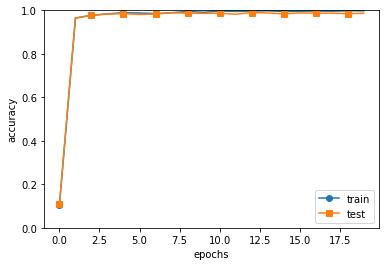

In [4]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

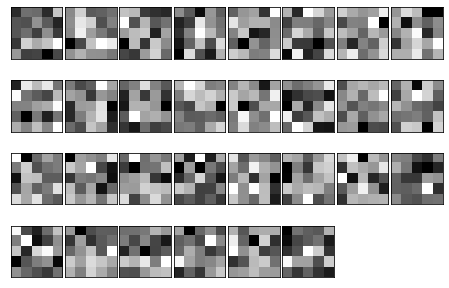

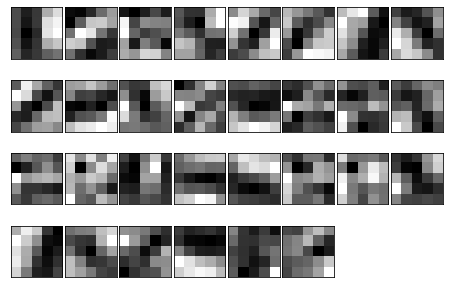

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])